# Information Retrieval Notebook


This exercise assumes that you are now familiar with concepts we have introduced in both the Warmup Exercise and Exercise 1, including:
 - [PyTerrier operators](https://pyterrier.readthedocs.io/en/latest/operators.html)
 - [Pyterrier apply transformers](https://pyterrier.readthedocs.io/en/latest/transformer.html)
 - [PyTerrier pt.Experiment()](https://pyterrier.readthedocs.io/en/latest/experiments.html)


## PyTerrier Setup

First, let's install PyTerrier as usual.

In [ ]:
%pip install -q python-terrier lightgbm==2.2.3

Let's start PyTerrier:

In [ ]:
import pyterrier as pt
if not pt.started():
  pt.init()

# we require a specific version of LightGBM for this exercise
import lightgbm
assert lightgbm.__version__ == '2.2.3'

PyTerrier 0.9.2 has loaded Terrier 5.7 (built by craigm on 2022-11-10 18:30) and terrier-helper 0.0.7



## Index, Topics & Qrels for Exercise
You will need your login & password credentials. We will be using the "50pct" and the "trec-wt-2004" datasets.


In [ ]:
UNAME=""
PWORD=""

# we will again be using the "50pct" and "trec-wt-2004" datasets
Fiftypct = pt.get_dataset("50pct",  user=UNAME, password=PWORD)
dotgov_topicsqrels = pt.get_dataset("trec-wt-2004")

You will be using a slightly updated index. It takes about 2-3 minutes to download to Colab.


In [ ]:

indexref = Fiftypct.get_index(variant="ex3")
index = pt.IndexFactory.of(indexref)


14:25:28.483 [main] WARN org.terrier.structures.BaseCompressingMetaIndex - Structure meta reading data file directly from disk (SLOW) - try index.meta.data-source=fileinmem in the index properties file. 860.9 MiB of memory would be required.


Let's check out the new index. You can see that this index has `Field Names: [TITLE, ELSE]`, which means that we can provide statistics about how many times each term occurs in the title of each document (the "TITLE" field), vs the rest of the document (the "ELSE" field). Refer to Lecture 8 for more information about fields.

Let's also display the keys in the meta index - this is the metadata that we have stored for each document. You can see that we are storing the "url" and the "body" (content) of the document. These will particularly come in handy for Q2 and Q3, respectively.


In [ ]:
print(index.getCollectionStatistics())
print("In the meta index: " + str(index.getMetaIndex().getKeys()))

Number of documents: 807775
Number of terms: 2043788
Number of postings: 177737957
Number of fields: 2
Number of tokens: 572916194
Field names: [TITLE, ELSE]
Positions:   false

In the meta index: ['docno', 'url', 'title', 'body']


Finally, these are all of the topics and qrels (including the training and validation datasets) that you will need to conduct Exercise 2.

In [ ]:
tr_topics = Fiftypct.get_topics("training")
va_topics = Fiftypct.get_topics("validation")

tr_qrels = Fiftypct.get_qrels("training")
va_qrels = Fiftypct.get_qrels("validation")

test_topics = dotgov_topicsqrels.get_topics("hp")
test_qrels = dotgov_topicsqrels.get_qrels("hp")

## Baseline Setup

We introduce here the BatchRetrieve for our baseline. Note that:
 - We are using PL2 as our weighting model to generate the candidate set of documents to re-rank.
 - We expose more document metadata, namely "url" and "body" for each document retrieved, which you will need to deploy your two new features.
 - By setting `verbose=True`, we display a progress bar while retrieval executes.

In [ ]:
firstpassUB = pt.BatchRetrieve(index, wmodel="PL2", metadata=["docno", "url", "body"], verbose=True)

Let's see the resulting output - you can see that there are now "url" and "body" attributes for each retrieved document. (We also display a progress bar, enabled by the `verbose=True`).

In [ ]:
firstpassUB.search("chemical reactions")

BR(PL2):   0%|          | 0/1 [00:00<?, ?q/s]

,qid,docid,docno,url,body,rank,score,query
0,1,513586,G18-38-1767991,http://www.boulder.nist.gov/div838/tar/file03....,NIST - Physical and Chemical Properties Divi...,0,12.755546,chemical reactions
1,1,38544,G01-14-2537005,http://www.labtrain.noaa.gov/shemtfa/chemhaz/n...,. ...,1,11.906524,chemical reactions
2,1,707122,G26-06-3754605,http://www.aps.anl.gov/xfd/tech/safetyenvelope...,APS Experiment Safety Envelope 6: Chemicals ...,2,11.877550,chemical reactions
3,1,382754,G13-59-3981168,http://response.restoration.noaa.gov/chemaids/...,"""); } else { document.write(...",3,11.858475,chemical reactions
4,1,70292,G02-16-2617043,http://www.symp14.nist.gov/PDF/COR04MAY.PDF,A Database of Chemical Reactions Designed to A...,4,11.731490,chemical reactions
...,...,...,...,...,...,...,...,...
995,1,246965,G08-68-4141101,http://en-env.llnl.gov/asd/pinatub.html,The Chemical and Radiative Effects of the Moun...,995,6.290707,chemical reactions
996,1,611136,G22-04-3955177,http://eospso.gsfc.nasa.gov/ftp_docs/Ch7.pdf,Chapter 7 ...,996,6.289822,chemical reactions
997,1,594957,G21-38-0191596,http://www.oit.doe.gov/news/oittimes/wn02/wn02...,search ...,997,6.287830,chemical reactions
998,1,280944,G09-85-3411646,http://www.ig.doe.gov/pdf/chemfina.pdf,INS-O-00-01 I N S P E C T I O N ...,998,6.287759,chemical reactions


# Standard list of features

Let's introduce the list of features we need to deploy a baseline learning-to-rank approach.

In [ ]:
pagerankfile = indexref + "/data-pagerank.oos"
features = [
    "SAMPLE", #ie PL2
    "WMODEL:SingleFieldModel(BM25,0)", #BM25 title
    "QI:StaticFeature(OIS,%s)" % pagerankfile,
]

stdfeatures = pt.FeaturesBatchRetrieve(index, features, verbose=True)
stage12 = firstpassUB >> stdfeatures

This is our feature set. We will be using FeaturesBatchRetrieve to compute these extra features on the fly. Let's see the output. You can see that there is now a "features" column.

In [ ]:
stage12.search("chemical reactions").head(2)

BR(PL2):   0%|          | 0/1 [00:00<?, ?q/s]

FBR(3 features):   0%|          | 0/1 [00:00<?, ?q/s]

,qid,query,docid,rank,features,docno,score
0,1,chemical reactions,513586,0,"[12.755545561073266, 3.0924078763629836, 0.000...",G18-38-1767991,12.755546
1,1,chemical reactions,38544,1,"[11.90652405775751, 10.789390732195702, 0.0002...",G01-14-2537005,11.906524


Let's look in more detail at the features. It is clear that there are 3 numbers for each document. The first is the PL2 score (1.27555456e+01 == 12.7555), the second is the BM25 score, and the third is the PageRank (a link analysis feature - discussed in more detail in Lecture 10)

In [ ]:
stage12.search("chemical reactions").head(1).iloc[0]["features"]

BR(PL2):   0%|          | 0/1 [00:00<?, ?q/s]

FBR(3 features):   0%|          | 0/1 [00:00<?, ?q/s]

array([1.27555456e+01, 3.09240788e+00, 1.05668333e-04])

# Q1

You now have everyting you need to attempt Q1. You will need to refer to the specification, and to PyTerrier's [learning to rank documentation](https://pyterrier.readthedocs.io/en/latest/ltr.html).

You should use a LightGBM LambdaMART implementation (*not* XGBoost), instantiated using the configuration suggested in the PyTerrier documentation.

Hints:
 - You will need to use the provided separate “training” and “validation” topic sets and qrels to train the learning-to-rank.
 - There is no need to vary the configuration of LightGBM from that in the documentation.

In [ ]:
from pyterrier.measures import *

In [ ]:
#YOUR SOLUTION
lmart_l = lightgbm.LGBMRanker(task="train",
    min_data_in_leaf=1,
    min_sum_hessian_in_leaf=100,
    max_bin=255,
    num_leaves=7,
    objective="lambdarank",
    metric="ndcg",
    ndcg_eval_at=[1, 3, 5, 10],
    learning_rate= .1,
    importance_type="gain",
    num_iterations=10)
lmart_l_pipe = stage12 >> pt.ltr.apply_learned_model(lmart_l, form="ltr")
lmart_l_pipe.fit(tr_topics, tr_qrels, va_topics, va_qrels)

pt.Experiment(
    [firstpassUB, lmart_l_pipe],
    test_topics,
    test_qrels,
    ["map", P@5],
    round = 4,
    baseline = 0,
    names=["PL2 Baseline", "LambdaMART (LightGBM)" ]
)

BR(PL2):   0%|          | 0/96 [00:00<?, ?q/s]

FBR(3 features):   0%|          | 0/96 [00:00<?, ?q/s]

BR(PL2):   0%|          | 0/54 [00:00<?, ?q/s]

FBR(3 features):   0%|          | 0/54 [00:00<?, ?q/s]

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's ndcg@1: 0.148148
[2]	valid_0's ndcg@1: 0.203704
[3]	valid_0's ndcg@1: 0.333333
[4]	valid_0's ndcg@1: 0.351852
[5]	valid_0's ndcg@1: 0.37037
[6]	valid_0's ndcg@1: 0.37037
[7]	valid_0's ndcg@1: 0.388889
[8]	valid_0's ndcg@1: 0.407407
[9]	valid_0's ndcg@1: 0.425926
[10]	valid_0's ndcg@1: 0.425926


BR(PL2):   0%|          | 0/75 [00:00<?, ?q/s]

BR(PL2):   0%|          | 0/75 [00:00<?, ?q/s]

FBR(3 features):   0%|          | 0/75 [00:00<?, ?q/s]

,name,map,P@5,map +,map -,map p-value,P@5 +,P@5 -,P@5 p-value
0,PL2 Baseline,0.2251,0.0693,NaN,NaN,NaN,NaN,NaN,NaN
1,LambdaMART (LightGBM),0.3579,0.1013,44.0,18.0,0.007377,18.0,7.0,0.02231


In [ ]:
pt.Experiment(
    [firstpassUB, lmart_l_pipe],
    test_topics,
    test_qrels,
    [AP],
    round = 4,
    baseline = 0,
    names=["PL2 Baseline", "LambdaMART (LightGBM)" ]
)

BR(PL2):   0%|          | 0/75 [00:00<?, ?q/s]

BR(PL2):   0%|          | 0/75 [00:00<?, ?q/s]

FBR(3 features):   0%|          | 0/75 [00:00<?, ?q/s]

,name,AP,AP +,AP -,AP p-value
0,PL2 Baseline,0.2251,NaN,NaN,NaN
1,LambdaMART (LightGBM),0.3579,44.0,18.0,0.007377


# Q2 - URL Length Features

In this block, please provide your code for Q2 concerning your two URL Length features, namely URL Length by counting slashes (URL-slashes) and URL Length through using the type of the URL (URL-type). The two different URL length features that you will need to implement are detailed in the specification. Do carefully read and follow the Exercise 2 specification before starting the implementation of the features.

Some hints:

 - For computing each of your URL features, you will need to use an appropriate [pt.apply function](https://pyterrier.readthedocs.io/en/latest/apply.html). The dataframe of results obtained from the `firstpassUB` transformer has all of the information you need.

 - You can use a `**` operator for combining feature sets.

 - Refer to the PyTerrier learning to rank documentation  concerning `feature_importances_` for obtaining feature importances.

 - You may wish to refer to Python's [`urlparse()`](https://docs.python.org/3/library/urllib.parse.html) function.

 - Use Python assertions to test that your feature implmentation(s) give the expected results.


## Q2 (a) URL-Slashes Feature

In this block you should define your URL-Slashes feature, and test it. Show clearly the tests you have conducted to test that your feature works as expected.

In [ ]:
#YOUR SOLUTION
import urllib.parse
import pandas as pd

# below function will take the dataframe row as parameter and get the url, and then return the count of slashes in that url
def url_slash(row):
    url = row['url']
    return url.count('/')

# TEST TO CHECK IF THE FEATURE IS WORKING AS EXPECTED
slash_count = []
urls = [
    'http://trec.nist.gov',
    'http://trec.nist.gov/pubs/',
    'http://trec.nist.gov/pubs/trec9/papers/',
    'http://trec.nist.giv/pubs/trec9/t9_proceedings.html',
    'https://www.chtips.com/disclaimer',
    'https://www.chtips.com/privacy-policy/',
    'http://dsrd.com/dir/slash/index.html',
    'http://bruh.com/index.html',
    'https://www.chtips.com/',
]
df = pd.DataFrame({'url': urls})
for i,r in df.iterrows():
  print(r)
  slash_count.append(url_slash(r))
print(slash_count)

url    http://trec.nist.gov
Name: 0, dtype: object
url    http://trec.nist.gov/pubs/
Name: 1, dtype: object
url    http://trec.nist.gov/pubs/trec9/papers/
Name: 2, dtype: object
url    http://trec.nist.giv/pubs/trec9/t9_proceedings...
Name: 3, dtype: object
url    https://www.chtips.com/disclaimer
Name: 4, dtype: object
url    https://www.chtips.com/privacy-policy/
Name: 5, dtype: object
url    http://dsrd.com/dir/slash/index.html
Name: 6, dtype: object
url    http://bruh.com/index.html
Name: 7, dtype: object
url    https://www.chtips.com/
Name: 8, dtype: object
[2, 4, 6, 5, 3, 4, 5, 3, 3]


#### (i) URL-Slashes as a PL2 re-ranker

Now you should evaluate your URL-slashes score by re-ranking PL2, without applying learning-to-rank. You can now answer the corresponding quiz questions.

In [ ]:
#YOUR SOLUTION

# first i will use doc_score() from pt then will re-rank PL2 using URL slashes score that i implemented
url_slashes = pt.apply.doc_score(url_slash, verbose=True)
urlSlash = firstpassUB >> url_slashes

In [ ]:
urlSlash.search('cryption').head()

BR(PL2):   0%|          | 0/1 [00:00<?, ?q/s]

pt.apply.doc_score:   0%|          | 0/10 [00:00<?, ?d/s]

,qid,docid,docno,url,body,score,query,rank
1,1,494954,G17-68-2584616,http://www.ncs.gov/n2/content/technote/tnv7n4/...,OFFICE OF THE MANAGER ...,7.0,cryption,0
0,1,434993,G15-50-1054100,http://cs-www.ncsl.nist.gov/publications/nistp...,"References[BOCK 88] Peter Bocker, ISDN The Int...",6.0,cryption,1
6,1,457024,G16-34-3764782,http://w3.access.gpo.gov/bxa/ear/txt/734.txt,Part 734--Scope of the Export Administration R...,6.0,cryption,2
7,1,424551,G15-11-3633588,http://cs-www.ncsl.nist.gov/publications/nistp...,Special Publication 800-41 Guidelines on Firew...,6.0,cryption,3
8,1,427549,G15-22-3805523,http://cs-www.ncsl.nist.gov/publications/nistp...,Security Issues in the Database Language SQLW....,6.0,cryption,4


In [ ]:
pt.Experiment(
    [urlSlash],
    test_topics,
    test_qrels,
    ["map",P@5],
    round = 4,
    names = ["URL Slashes"],
)

BR(PL2):   0%|          | 0/75 [00:00<?, ?q/s]

pt.apply.doc_score:   0%|          | 0/74229 [00:00<?, ?d/s]

,name,map,P@5
0,URL Slashes,0.0022,0.0


#### (ii) URL-Slashes within an LTR model

Now you should evaluate your URL-slashes score as a feature within a new learned model. You can now answer the corresponding quiz questions.

In [ ]:
#YOUR SOLUTION

lmart_l_forurlslash = lightgbm.LGBMRanker(task="train",  #creating the LightGBM model
    min_data_in_leaf=1,
    min_sum_hessian_in_leaf=100,
    max_bin=255,
    num_leaves=7,
    objective="lambdarank",
    metric="ndcg",
    ndcg_eval_at=[1, 3, 5, 10],
    learning_rate= .1,
    importance_type="gain",
    num_iterations=10)
urlSlash_withLTR = firstpassUB >> (pt.FeaturesBatchRetrieve(index,features,verbose = True) ** url_slashes)  # combining feature set url_slashes and implementing with LTR
lmart_l_pipe_URLSlash = urlSlash_withLTR >> pt.ltr.apply_learned_model(lmart_l_forurlslash, form="ltr")
lmart_l_pipe_URLSlash.fit(tr_topics, tr_qrels, va_topics, va_qrels)

BR(PL2):   0%|          | 0/96 [00:00<?, ?q/s]

FBR(3 features):   0%|          | 0/96 [00:00<?, ?q/s]

pt.apply.doc_score:   0%|          | 0/94170 [00:00<?, ?d/s]

BR(PL2):   0%|          | 0/54 [00:00<?, ?q/s]

FBR(3 features):   0%|          | 0/54 [00:00<?, ?q/s]

pt.apply.doc_score:   0%|          | 0/53209 [00:00<?, ?d/s]

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's ndcg@1: 0.166667
[2]	valid_0's ndcg@1: 0.222222
[3]	valid_0's ndcg@1: 0.333333
[4]	valid_0's ndcg@1: 0.333333
[5]	valid_0's ndcg@1: 0.333333
[6]	valid_0's ndcg@1: 0.407407
[7]	valid_0's ndcg@1: 0.462963
[8]	valid_0's ndcg@1: 0.574074
[9]	valid_0's ndcg@1: 0.592593
[10]	valid_0's ndcg@1: 0.574074


In [ ]:
pt.Experiment(
    [lmart_l_pipe, lmart_l_pipe_URLSlash],
    test_topics,
    test_qrels,
    eval_metrics = ["map", P@5],
    round = 4,
    baseline = 0,       #baselining our previous LTR ranking model to check performance with URL slash feature
    names=["LambdaMART (LightGBM)", "LambdaMART (LightGBM) with URL Slash" ]
)

BR(PL2):   0%|          | 0/75 [00:00<?, ?q/s]

FBR(3 features):   0%|          | 0/75 [00:00<?, ?q/s]

BR(PL2):   0%|          | 0/75 [00:00<?, ?q/s]

FBR(3 features):   0%|          | 0/75 [00:00<?, ?q/s]

pt.apply.doc_score:   0%|          | 0/74229 [00:00<?, ?d/s]

,name,map,P@5,map +,map -,map p-value,P@5 +,P@5 -,P@5 p-value
0,LambdaMART (LightGBM),0.3579,0.1013,NaN,NaN,NaN,NaN,NaN,NaN
1,LambdaMART (LightGBM) with URL Slash,0.4296,0.1227,26.0,19.0,0.048966,10.0,3.0,0.044734


In [ ]:
withLTR = pt.Experiment(
    [lmart_l_pipe],
    test_topics,
    test_qrels,
    [AP,P@5],
    round = 4,
    perquery = "true",
    names=["LambdaMART (LightGBM)" ]
)
with4LTR = pt.Experiment(
    [lmart_l_pipe_URLSlash],
    test_topics,
    test_qrels,
    [AP,P@5],
    round = 4,
    perquery = "true",
    names=["LambdaMART (LightGBM) with URL Slash" ]
)

BR(PL2):   0%|          | 0/75 [00:00<?, ?q/s]

FBR(3 features):   0%|          | 0/75 [00:00<?, ?q/s]

BR(PL2):   0%|          | 0/75 [00:00<?, ?q/s]

FBR(3 features):   0%|          | 0/75 [00:00<?, ?q/s]

pt.apply.doc_score:   0%|          | 0/74229 [00:00<?, ?d/s]

In [ ]:
with4LTR

,name,qid,measure,value
62,LambdaMART (LightGBM) with URL Slash,106,AP,0.5000
63,LambdaMART (LightGBM) with URL Slash,106,P@5,0.2000
64,LambdaMART (LightGBM) with URL Slash,108,AP,0.0323
65,LambdaMART (LightGBM) with URL Slash,108,P@5,0.0000
66,LambdaMART (LightGBM) with URL Slash,109,AP,0.0833
...,...,...,...,...
57,LambdaMART (LightGBM) with URL Slash,94,P@5,0.2000
58,LambdaMART (LightGBM) with URL Slash,95,AP,0.0179
59,LambdaMART (LightGBM) with URL Slash,95,P@5,0.0000
60,LambdaMART (LightGBM) with URL Slash,98,AP,0.5000


In [ ]:
dff = with4LTR.merge(withLTR, how='inner', on=['qid','measure'])
dff['delta']=dff['value_x']-dff['value_y']
#dff
poscountp5 = 0
poscountap = 0
for i,r in dff.iterrows():
  if r['delta']>0 and r['measure'] == "AP":
    poscountap+= 1
  if r['delta']>0 and r['measure'] == "P@5":
    poscountp5+= 1
print(poscountap)
print(poscountp5)

26
10


In [ ]:
featureimpwith4 = lmart_l_forurlslash.feature_importances_
featureimpwith4

array([ 94151.14263916,  57201.97506332, 291511.49111938,  13280.45355606])

In [ ]:
features4 = [    "SAMPLE", "WMODEL:SingleFieldModel(BM25,0)", "QI:StaticFeature(OIS,%s)", "URL Slash"]
featuredf = pd.DataFrame({'features': features4, 'featureimp': featureimpwith4})
featuredf = featuredf.sort_values(by=['featureimp'], ascending=False)
featuredf["rank"] = [1,2,3,4]
featuredf

,features,featureimp,rank
2,"QI:StaticFeature(OIS,%s)",291511.491119,1
0,SAMPLE,94151.142639,2
1,"WMODEL:SingleFieldModel(BM25,0)",57201.975063,3
3,URL Slash,13280.453556,4


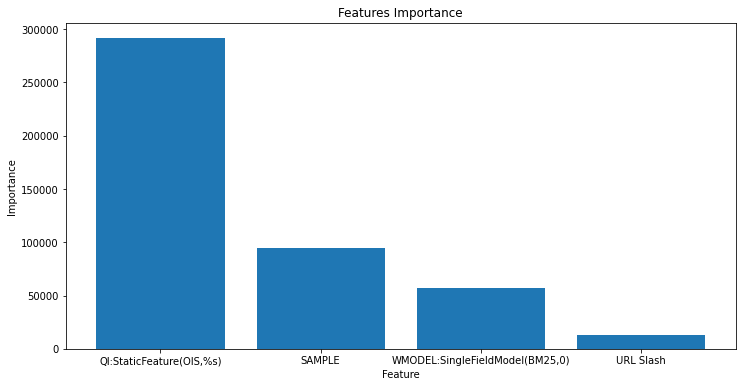

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.title("Features Importance")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.bar(featuredf['features'],featuredf['featureimp'])
plt.show()

## Q2 (b) URL Type Feature

In this block you should define your URL Type feature and test it. Show clearly the tests you have conducted to test that your feature works as expected.

In [ ]:
#YOUR SOLUTION
def url_type(row):
  #parsing the URL using urllib
  parsed_url = urllib.parse.urlparse(row['url'])
  #extracting the path from the url obtained
  path = parsed_url.path
  #print(path)
  #for the url to be root type, the path might be empty, or a single '/', or even '/index.html', as seen in the examples
  if path == '' or path == '/index.html' or path == '/':
    return 0  # root
  #for the url to be subroot type, the path will have only 2 '/'s since it will just contain one sub path, and may or maynot end with index.html
  elif path.count('/') == 2 and (path.endswith('/') or path.endswith('/index.html')):
    return 1  # subroot
  #for the url to be path type, it will have more than one arbitrary deep path, but not ending in a file name other than “index.html”
  elif path.count('/') > 2 and (path.endswith('/') or path.endswith('/index.html')):
    return 2  # path
  #any url ending with a file name other than index.html
  else:
    return 3  # file

# TEST TO CHECK IF THE FEATURE IS WORKING AS EXPECTED
urls = [
    'http://trec.nist.gov',
    'http://trec.nist.gov/pubs/',
    'http://trec.nist.gov/pubs/trec9/papers/',
    'http://trec.nist.giv/pubs/trec9/t9_proceedings.html',
    'https://www.chtips.com/disclaimer',
    'https://www.chtips.com/privacy-policy/',
    'http://dsrd.com/dir/slash/index.html',
    'http://bruh.com/index.html',
    'https://www.chtips.com/',
]
df = pd.DataFrame({'url': urls})
url_types = []
for i,r in df.iterrows():
  print(r)
  url_types.append(url_type(r))
print(url_types)

url    http://trec.nist.gov
Name: 0, dtype: object
url    http://trec.nist.gov/pubs/
Name: 1, dtype: object
url    http://trec.nist.gov/pubs/trec9/papers/
Name: 2, dtype: object
url    http://trec.nist.giv/pubs/trec9/t9_proceedings...
Name: 3, dtype: object
url    https://www.chtips.com/disclaimer
Name: 4, dtype: object
url    https://www.chtips.com/privacy-policy/
Name: 5, dtype: object
url    http://dsrd.com/dir/slash/index.html
Name: 6, dtype: object
url    http://bruh.com/index.html
Name: 7, dtype: object
url    https://www.chtips.com/
Name: 8, dtype: object
[0, 1, 2, 3, 3, 1, 2, 0, 0]


#### (i) URL Type as a PL2 re-ranker

Now you should evaluate your URL type score by re-ranking PL2, without applying learning-to-rank. You can now answer the corresponding quiz questions.

In [ ]:
#YOUR SOLUTION
urlTypes = pt.apply.doc_score(url_type, verbose=True)
urlType = firstpassUB >> urlTypes

In [ ]:
urlType.search('aaie').head()

BR(PL2):   0%|          | 0/1 [00:00<?, ?q/s]

pt.apply.doc_score:   0%|          | 0/6 [00:00<?, ?d/s]

,qid,docid,docno,url,body,score,query,rank
1,1,88532,G02-80-0379929,http://sunshine.jpl.nasa.gov/1rst%20Tier/Photo...,C ol o Photo Album This section is f...,3.0,aaie,0
2,1,301428,G10-61-1895354,http://www.cdpr.ca.gov/docs/ipminov/01awards.htm,The 2001 IPM Innovators Awards The 2001 A...,3.0,aaie,1
3,1,375914,G13-35-3399834,http://www.cdpr.ca.gov/docs/pressrls/9pestinno...,Media Contacts: Glenn Brank 916/445-3974 ...,3.0,aaie,2
0,1,543541,G19-52-0995113,http://sunshine.jpl.nasa.gov/AAIE%20Site%20%c4...,AAIE Photo Album The Jet Propulsion Labo...,2.0,aaie,3
4,1,51341,G01-54-3873617,http://goldmine.cde.ca.gov/calendar/,BODY { margin-left : 0; margin-...,1.0,aaie,4


In [ ]:
pt.Experiment(
    [urlType],
    test_topics,
    test_qrels,
    ["map",P@5],
    round = 4,
    names = ["URL Types"],
)

BR(PL2):   0%|          | 0/75 [00:00<?, ?q/s]

pt.apply.doc_score:   0%|          | 0/74229 [00:00<?, ?d/s]

,name,map,P@5
0,URL Types,0.0013,0.0


#### (ii) URL Type within an LTR model

Now you should evaluate your URL type score as a feature within a new learned model. You can now answer the corresponding quiz questions.

In [ ]:
#YOUR SOLUTION
lmart_l_forURLTYPE = lightgbm.LGBMRanker(task="train",
    min_data_in_leaf=1,
    min_sum_hessian_in_leaf=100,
    max_bin=255,
    num_leaves=7,
    objective="lambdarank",
    metric="ndcg",
    ndcg_eval_at=[1, 3, 5, 10],
    learning_rate= .1,
    importance_type="gain",
    num_iterations=10)
urlType_withLTR = firstpassUB >> (pt.FeaturesBatchRetrieve(index,features,verbose = True) ** urlTypes)
lmart_l_pipe_URLType = urlType_withLTR >> pt.ltr.apply_learned_model(lmart_l_forURLTYPE, form="ltr")
lmart_l_pipe_URLType.fit(tr_topics, tr_qrels, va_topics, va_qrels)

BR(PL2):   0%|          | 0/96 [00:00<?, ?q/s]

FBR(3 features):   0%|          | 0/96 [00:00<?, ?q/s]

pt.apply.doc_score:   0%|          | 0/94170 [00:00<?, ?d/s]

BR(PL2):   0%|          | 0/54 [00:00<?, ?q/s]

FBR(3 features):   0%|          | 0/54 [00:00<?, ?q/s]

pt.apply.doc_score:   0%|          | 0/53209 [00:00<?, ?d/s]

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's ndcg@1: 0.166667
[2]	valid_0's ndcg@1: 0.296296
[3]	valid_0's ndcg@1: 0.407407
[4]	valid_0's ndcg@1: 0.444444
[5]	valid_0's ndcg@1: 0.537037
[6]	valid_0's ndcg@1: 0.518519
[7]	valid_0's ndcg@1: 0.518519
[8]	valid_0's ndcg@1: 0.574074
[9]	valid_0's ndcg@1: 0.611111
[10]	valid_0's ndcg@1: 0.611111


In [ ]:
pt.Experiment(
    [lmart_l_pipe, lmart_l_pipe_URLType],
    test_topics,
    test_qrels,
    ["map", P@5],
    round = 4,
    baseline = 0,
    names=["LambdaMART (LightGBM)","LambdaMART (LightGBM) with URL Type" ]
)

BR(PL2):   0%|          | 0/75 [00:00<?, ?q/s]

FBR(3 features):   0%|          | 0/75 [00:00<?, ?q/s]

BR(PL2):   0%|          | 0/75 [00:00<?, ?q/s]

FBR(3 features):   0%|          | 0/75 [00:00<?, ?q/s]

pt.apply.doc_score:   0%|          | 0/74229 [00:00<?, ?d/s]

,name,map,P@5,map +,map -,map p-value,P@5 +,P@5 -,P@5 p-value
0,LambdaMART (LightGBM),0.3579,0.1013,NaN,NaN,NaN,NaN,NaN,NaN
1,LambdaMART (LightGBM) with URL Type,0.4592,0.1333,30.0,24.0,0.014462,12.0,4.0,0.038731


In [ ]:
pt.Experiment(
    [lmart_l_pipe_URLType],
    test_topics,
    test_qrels,
    [P@1],
    round = 4,
    names=["LambdaMART (LightGBM) with URL Type" ]
)

BR(PL2):   0%|          | 0/75 [00:00<?, ?q/s]

FBR(3 features):   0%|          | 0/75 [00:00<?, ?q/s]

pt.apply.doc_score:   0%|          | 0/74229 [00:00<?, ?d/s]

,name,P@1
0,LambdaMART (LightGBM) with URL Type,0.36


In [ ]:
with4LTR_urltype = pt.Experiment(
    [lmart_l_pipe_URLType],
    test_topics,
    test_qrels,
    [AP,P@5],
    round = 4,
    perquery = "true",
    names=["LambdaMART (LightGBM) with URL Type" ]
)

BR(PL2):   0%|          | 0/75 [00:00<?, ?q/s]

FBR(3 features):   0%|          | 0/75 [00:00<?, ?q/s]

pt.apply.doc_score:   0%|          | 0/74229 [00:00<?, ?d/s]

In [ ]:
dff2 = with4LTR_urltype.merge(withLTR, how='inner', on=['qid','measure'])
dff2['delta']=dff2['value_x']-dff2['value_y']
#dff2
Poscountp5 = 0
Poscountap = 0
for i,r in dff2.iterrows():
  if r['delta']>0 and r['measure'] == "AP":
    Poscountap+= 1
  if r['delta']>0 and r['measure'] == "P@5":
    Poscountp5+= 1
print(Poscountap)
print(Poscountp5)

30
12


In [ ]:
featureimpwith4_type = lmart_l_forURLTYPE.feature_importances_
featureimpwith4_type

array([ 89200.10369873,  49779.56082916, 320279.50985909,  46670.70906067])

In [ ]:
features4_ = [    "SAMPLE", "WMODEL:SingleFieldModel(BM25,0)", "QI:StaticFeature(OIS,%s)", "URL Type"]
featuretypedf = pd.DataFrame({'features': features4_, 'featureimp': featureimpwith4_type})
featuretypedf = featuretypedf.sort_values(by=['featureimp'], ascending=False)
featuretypedf["rank"] = [1,2,3,4]
featuretypedf

,features,featureimp,rank
2,"QI:StaticFeature(OIS,%s)",320279.509859,1
0,SAMPLE,89200.103699,2
1,"WMODEL:SingleFieldModel(BM25,0)",49779.560829,3
3,URL Type,46670.709061,4


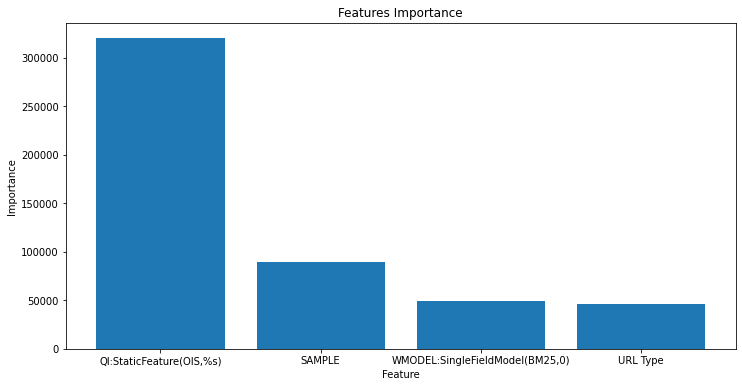

In [ ]:
plt.figure(figsize=(12,6))
plt.title("Features Importance")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.bar(featuretypedf['features'],featuretypedf['featureimp'])
plt.show()

# Q3 Proximity Search Feature

Now you will implement a new query-dependent feature, using the MinDist() function, as discussed in the specification. Do carefully read the Exercise 2 specification before starting the implementation.

Hints:
 - Again, remember to use assertions to test your feature implementations.
 - Refer to the PyTerrier learning to rank documentation concerning features_importances_ for obtaining feature importances

As mentioned in the specification, you should implement a function called `avgmindist()`, which takes the text of the query and the text of the document, and returns a score for the document, i.e. it must conform to the following Python specification:
```python
def avgmindist(query : str, document : str) -> float
```

NB: There are particular specific requirements for your implementations of MinDist() and avgmindist() that are detailed in the specification.

In [ ]:
#YOUR AVGMINDIST IMPLEMENTATION
import re
import numpy as np

def MinDist(a, b, D):
    # Get the positions of a and b in the document
    pos_a = [m.start() for m in re.finditer(a, D)]
    pos_b = [m.start() for m in re.finditer(b, D)]

    # Calculate the minimum distance between any occurrences of a and b
    min_dist = float('inf')
    for i in range(len(pos_a)):
        for j in range(len(pos_b)):
            dist = abs(pos_a[i] - pos_b[j])
            if dist < min_dist:
                min_dist = dist

    return min_dist


def avgmindist(query : str, document : str) -> float:
  #update your implementation here.
  # Remove punctuation and convert to lowercase
    document = re.sub(r'[^\w\s]', '', document).lower()

    # Split the query into terms and calculate MinDist for each term
    query_terms = query.split()
    dists = []
    for i in range(len(query_terms) - 1):
        dist = MinDist(query_terms[i], query_terms[i+1], document)
        dists.append(dist)

    # Calculate the aggregated value
    if len(dists) == 0:
        agg_value = len(document.split())
    else:
        agg_value = np.mean(dists)

    return agg_value

# TESTING MY IMPLEMENTATION
queries = [
    "artificial refers",
    "key across",
    "deep machine",
    "applications predicting"
]

documents = [
    "Artificial intelligence (AI) refers to the simulation of human intelligence in machines that are programmed to think like humans and mimic their actions.",
    "AI has become a key driver of innovation across all industries, from healthcare to finance to transportation.",
    "Deep learning is a subset of machine learning that uses artificial neural networks to model and solve complex problems.",
    "Machine learning is a type of artificial intelligence that allows software applications to become more accurate in predicting outcomes without being explicitly programmed."
]
avg_min_dist = []
DF = pd.DataFrame({"query": queries, "document": documents})
for i,r in DF.iterrows():
  avg_min_dist.append(avgmindist(r['query'],r['document']))
avg_min_dist

[27.0, 25.0, 29.0, 40.0]

You should test your impementation yourself (your code must list the test cases you deployed to test that your feature works as expected). However, to also allow us to verify your implementation, we have created 9 testcases. Please run `run_test_cases()` and use its responses to answer the relevant quiz questions.

Hint:
 - Our test cases took around 1-3ms each. If the testing of your implementation takes magnitudes of time longer, then this will impact upon how long it takes you to train and evaluate your implementation within a LTR pipeline.


In [ ]:
#DO NOT ALTER THIS CELL
TEST_CASES = [
  ('fermilab directory', 45, 567257), #1
  ('webcam', 45, 567257), #2
  ('DOM surface', 384034, 388292), #3
  ('DOM surface', 45, 384034), #4
  ('DOM surface document', 388292, 384034), #5
  ('DOM software AMANDA', 639302, 384034), #6
  ('fermilab directory', 388292, 384034), #7
  ('trigger data', 596532, 639302), #8
  ('underlying hardware', 384034, 333649) #9
]

def run_test_cases():
  import datetime
  docno=0
  body=3
  for i, (query, docid1, docid2) in enumerate(TEST_CASES):
    start = datetime.datetime.now()
    meta1 = index.getMetaIndex().getAllItems(docid1)
    meta2 = index.getMetaIndex().getAllItems(docid2)
    s1 = avgmindist(query, meta1[body])
    s2 = avgmindist(query, meta2[body])
    if s1 > s2:
      result = meta1[docno]
      cmpD = "%s > %s" % (meta1[docno],meta2[docno])
    elif s2 > s1:
      result = meta2[docno]
      cmpD = "%s > %s" % (meta2[docno],meta1[docno])
    else:
      result = "EQUAL"
      cmpD = "%s == %s" % (meta1[docno],meta2[docno])
    end = datetime.datetime.now()
    print("TEST CASE %d result %s time %d ms" % (i+1, result, float((end-start).microseconds)/1000.))

run_test_cases()

TEST CASE 1 result G20-36-1335992 time 1 ms
TEST CASE 2 result G20-36-1335992 time 1 ms
TEST CASE 3 result EQUAL time 1 ms
TEST CASE 4 result EQUAL time 0 ms
TEST CASE 5 result EQUAL time 0 ms
TEST CASE 6 result EQUAL time 0 ms
TEST CASE 7 result EQUAL time 0 ms
TEST CASE 8 result G21-44-1000362 time 0 ms
TEST CASE 9 result G11-79-2454097 time 1 ms


You should now integrate your avgmindist() function into a new LTR model, and compare its MAP & P@5 performance to the LTR baseline. You can now answer the corresponding quiz questions.

In [ ]:
#YOUR SOLUTION
def avgmin(df):
  return avgmindist(df.query,df.body)
dist_score = pt.apply.doc_score(avgmin, verbose = True)

In [ ]:
dist_score_withfeatures = firstpassUB >> (pt.FeaturesBatchRetrieve(index, features, verbose = True) ** dist_score)
lmart_l_distance = lightgbm.LGBMRanker(task="train",
    min_data_in_leaf=1,
    min_sum_hessian_in_leaf=100,
    max_bin=255,
    num_leaves=7,
    objective="lambdarank",
    metric="ndcg",
    ndcg_eval_at=[1, 3, 5, 10],
    learning_rate= .1,
    importance_type="gain",
    num_iterations=10)
lmart_l_pipe_dist = dist_score_withfeatures >> pt.ltr.apply_learned_model(lmart_l_distance, form="ltr")
lmart_l_pipe_dist.fit(tr_topics, tr_qrels, va_topics, va_qrels)

BR(PL2):   0%|          | 0/96 [00:00<?, ?q/s]

FBR(3 features):   0%|          | 0/96 [00:00<?, ?q/s]

pt.apply.doc_score:   0%|          | 0/94170 [00:00<?, ?d/s]

BR(PL2):   0%|          | 0/54 [00:00<?, ?q/s]

FBR(3 features):   0%|          | 0/54 [00:00<?, ?q/s]

pt.apply.doc_score:   0%|          | 0/53209 [00:00<?, ?d/s]

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's ndcg@1: 0.148148
[2]	valid_0's ndcg@1: 0.203704
[3]	valid_0's ndcg@1: 0.351852
[4]	valid_0's ndcg@1: 0.37037
[5]	valid_0's ndcg@1: 0.481481
[6]	valid_0's ndcg@1: 0.481481
[7]	valid_0's ndcg@1: 0.481481
[8]	valid_0's ndcg@1: 0.462963
[9]	valid_0's ndcg@1: 0.444444
[10]	valid_0's ndcg@1: 0.462963


In [ ]:
pt.Experiment(
    [lmart_l_pipe, lmart_l_pipe_dist],
    test_topics,
    test_qrels,
    ["map", P@5],
    round = 4,
    baseline = 0,
    names=["LambdaMART (LightGBM)","LambdaMART (LightGBM) with distance score" ]
)

BR(PL2):   0%|          | 0/75 [00:00<?, ?q/s]

FBR(3 features):   0%|          | 0/75 [00:00<?, ?q/s]

BR(PL2):   0%|          | 0/75 [00:00<?, ?q/s]

FBR(3 features):   0%|          | 0/75 [00:00<?, ?q/s]

pt.apply.doc_score:   0%|          | 0/74229 [00:00<?, ?d/s]

,name,map,P@5,map +,map -,map p-value,P@5 +,P@5 -,P@5 p-value
0,LambdaMART (LightGBM),0.3579,0.1013,NaN,NaN,NaN,NaN,NaN,NaN
1,LambdaMART (LightGBM) with distance score,0.3733,0.1200,27.0,16.0,0.471159,11.0,4.0,0.070416


In [ ]:
with4LTR_avgmin = pt.Experiment(
    [lmart_l_pipe_dist],
    test_topics,
    test_qrels,
    [AP,P@5],
    round = 4,
    perquery = "true",
    names=["LambdaMART (LightGBM) with avgmin" ]
)

BR(PL2):   0%|          | 0/75 [00:00<?, ?q/s]

FBR(3 features):   0%|          | 0/75 [00:00<?, ?q/s]

pt.apply.doc_score:   0%|          | 0/74229 [00:00<?, ?d/s]

In [ ]:
dff3 = with4LTR_avgmin.merge(withLTR, how='inner', on=['qid','measure'])
dff3['delta']=dff3['value_x']-dff3['value_y']
#dff3
improved = 0
hurt = 0
for i,r in dff3.iterrows():
  if r['delta']>0 and r['measure'] == "P@5":
    improved= 1
  if r['delta']<0 and r['measure'] == "P@5":
    hurt+= 1
print(improved)
print(hurt)

1
4


# Q4 A 5-feature Learning-to-Rank Model

You will now experiment with the LightGBM LambdaMART technique where you include both your added features (URL Type and AvgMinDist) along with the 3 initial features inc initial PL2 candidate set (5 features in total).

You need to learn a *new* model when using your final selection of 5 features.

Evaluate the performance of your resulting LTR system in comparison to the LTR baseline and answer the quiz questions.

In [ ]:
#YOUR SOLUTION
final5 = firstpassUB >> (pt.FeaturesBatchRetrieve(index, features, verbose = True) **urlTypes ** dist_score)
lmart_l_for5features = lightgbm.LGBMRanker(task="train",
    min_data_in_leaf=1,
    min_sum_hessian_in_leaf=100,
    max_bin=255,
    num_leaves=7,
    objective="lambdarank",
    metric="ndcg",
    ndcg_eval_at=[1, 3, 5, 10],
    learning_rate= .1,
    importance_type="gain",
    num_iterations=10)
lmart_l_pipe_5feat = final5 >> pt.ltr.apply_learned_model(lmart_l_for5features, form="ltr")
lmart_l_pipe_5feat.fit(tr_topics, tr_qrels, va_topics, va_qrels)

BR(PL2):   0%|          | 0/96 [00:00<?, ?q/s]

FBR(3 features):   0%|          | 0/96 [00:00<?, ?q/s]

pt.apply.doc_score:   0%|          | 0/94170 [00:00<?, ?d/s]

pt.apply.doc_score:   0%|          | 0/94170 [00:00<?, ?d/s]

BR(PL2):   0%|          | 0/54 [00:00<?, ?q/s]

FBR(3 features):   0%|          | 0/54 [00:00<?, ?q/s]

pt.apply.doc_score:   0%|          | 0/53209 [00:00<?, ?d/s]

pt.apply.doc_score:   0%|          | 0/53209 [00:00<?, ?d/s]

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's ndcg@1: 0.166667
[2]	valid_0's ndcg@1: 0.259259
[3]	valid_0's ndcg@1: 0.259259
[4]	valid_0's ndcg@1: 0.388889
[5]	valid_0's ndcg@1: 0.425926
[6]	valid_0's ndcg@1: 0.425926
[7]	valid_0's ndcg@1: 0.425926
[8]	valid_0's ndcg@1: 0.425926
[9]	valid_0's ndcg@1: 0.407407
[10]	valid_0's ndcg@1: 0.555556


In [ ]:
pt.Experiment(
    [lmart_l_pipe, lmart_l_pipe_5feat],
    test_topics,
    test_qrels,
    ["map", P@5],
    round = 4,
    baseline = 0,
    names=["LambdaMART (LightGBM)","LambdaMART (LightGBM) with 5 features" ]
)

BR(PL2):   0%|          | 0/75 [00:00<?, ?q/s]

FBR(3 features):   0%|          | 0/75 [00:00<?, ?q/s]

BR(PL2):   0%|          | 0/75 [00:00<?, ?q/s]

FBR(3 features):   0%|          | 0/75 [00:00<?, ?q/s]

pt.apply.doc_score:   0%|          | 0/74229 [00:00<?, ?d/s]

pt.apply.doc_score:   0%|          | 0/74229 [00:00<?, ?d/s]

,name,map,P@5,map +,map -,map p-value,P@5 +,P@5 -,P@5 p-value
0,LambdaMART (LightGBM),0.3579,0.1013,NaN,NaN,NaN,NaN,NaN,NaN
1,LambdaMART (LightGBM) with 5 features,0.4567,0.1387,39.0,12.0,0.008731,14.0,4.0,0.018592


In [ ]:
with5LTR = pt.Experiment(
    [lmart_l_pipe_5feat],
    test_topics,
    test_qrels,
    [AP,P@5],
    round = 4,
    perquery = "true",
    names=["LambdaMART (LightGBM) with 5 features" ]
)

BR(PL2):   0%|          | 0/75 [00:00<?, ?q/s]

FBR(3 features):   0%|          | 0/75 [00:00<?, ?q/s]

pt.apply.doc_score:   0%|          | 0/74229 [00:00<?, ?d/s]

pt.apply.doc_score:   0%|          | 0/74229 [00:00<?, ?d/s]

In [ ]:
dff4 = with5LTR.merge(withLTR, how='inner', on=['qid','measure'])
dff4['delta']=dff4['value_x']-dff4['value_y']
#dff3
improved_ = 0
hurt_ = 0
for i,r in dff4.iterrows():
  if r['delta']>0 and r['measure'] == "P@5":
    improved_= 1
  if r['delta']<0 and r['measure'] == "P@5":
    hurt_+= 1
print(improved_)
print(hurt_)

1
4


In [ ]:
lmart_l_for5features.feature_importances_

array([ 83778.06988525,  47278.3131485 , 271988.06015205,  32576.70497131,
        72518.64971924])